In [248]:
from turtle import TPen, color
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout

In [249]:
def get_ace_values(temp_list):
    '''
    This function lists out all permutations of ace values in the array sum_array
    For example, if you have 2 aces, there are 4 permutations:
        [[1,1], [1,11], [11,1], [11,11]]
    These permutations lead to 3 unique sums: [2, 12, 22]
    of these 3, only 2 are <=21 so they are returned: [2, 12]
    '''
    sum_array = np.zeros((2**len(temp_list), len(temp_list)))
    # This loop gets the permutations
    for i in range(len(temp_list)):
        n = len(temp_list) - i
        half_len = int(2**n * 0.5)
        for rep in range(int(sum_array.shape[0]/half_len/2)): #⭐️ shape[0] 返回 numpy 数组的行数
            sum_array[rep*2**n : rep*2**n+half_len, i] = 1
            sum_array[rep*2**n+half_len : rep*2**n+half_len*2, i] = 11
    # Only return values that are valid (<=21)
    # return list(set([int(s) for s in np.sum(sum_array, axis=1) if s<=21])) #⭐️ 将所有 'A' 能组成总和不超过 21 的值返回
    return [int(s) for s in np.sum(sum_array, axis=1)] #⭐️ 将所有 'A' 能组成的点数以 int 类型返回（有重复和超过 21 点的值）


def ace_values(num_aces):
    '''
    Convert num_aces, an int to a list of lists 
    For example, if num_aces=2, the output should be [[1,11],[1,11]]
    I require this format for the get_ace_values function
    '''
    temp_list = []
    for i in range(num_aces):
        temp_list.append([1,11])
    return get_ace_values(temp_list)

In [250]:
def func(x):
    '''
    判断玩家起手是否为 21 点
    '''
    if x == 21:
        return 1
    else:
        return 0

In [251]:
def make_decks(num_decks, card_types):
    '''
    Make a deck -- 根据给定副数洗好牌
    input:
        num_decks -> 牌副数
        card_types -> 单副牌单个花色对应的牌值
    output:
        new_deck -> 一副牌对应牌值
    '''
    new_deck = []
    for i in range(num_decks):
        for j in range(4): # 代表黑红梅方
            new_deck.extend(card_types) #⭐️ extend() 函数用于在列表末尾一次性追加另一个序列中的多个值
    random.shuffle(new_deck)
    return new_deck

In [252]:
def total_up(hand):
    '''
    Total up value of hand
    input:
        <list> hand -> 当前手牌组合
    output:
        <int>  ->  计算当前手牌的合法值
    '''
    aces = 0 # 记录 ‘A’ 的数目
    total = 0 # 记录除 ‘A’ 以外数字之和
    
    for card in hand:
        if card != 'A':
            total += card
        else:
            aces += 1
            
    # Call function ace_values to produce list of possible values for aces in hand
    ace_value_list = ace_values(aces)
    final_totals = [i+total for i in ace_value_list if i+total<=21] # ‘A’ 可以是 1 也可以是 11，当前牌值不超过 21 时，取最大值 -- 规则❗️

    if final_totals == []:
        return min(ace_value_list) + total
    else:
        return max(final_totals)

In [253]:
def model_decision_old(model, player_sum, has_ace, dealer_card_num, hit=0, card_count=None):
    '''
    Given the relevant inputs, the function below uses the neural net to make a prediction 
    and then based on that prediction, decides whether to hit or stay
    —— 将玩家各参数传入神经网络模型，如果预测结果大于 0.52, 则 hit, 否则 stand
    input:
        model -> 模型（一般指 NN 模型）
        player_sum -> 玩家当前手牌和
        has_ace -> 玩家发牌是否有 'A'
        dealer_card_num -> 庄家发牌（明牌）值
        hit -> 玩家是否‘要牌’
        card_count -> 记牌器
    return:
        1 -> hit
        0 -> stand
    '''
    # 将需要进入神经网络模型的数据统一格式
    # [[18  0  0  6]]
    input_array = np.array([player_sum, hit, has_ace, dealer_card_num]).reshape(1, -1) # 二维数组变成一行 (1, n)
    cc_array = pd.DataFrame.from_dict([card_count])
    input_array = np.concatenate([input_array, cc_array], axis=1)
    # print(input_array)
    
    # input_array 作为输入传入神经网络，使用预测函数后存入 predict_correct
    # [[0.10379896]]
    predict_correct = model.predict(input_array)
    # print(predict_correct)
    if predict_correct >= 0.52:
        return 1
    else:
        return 0

In [254]:
def model_decision(model, card_count, dealer_card_num):
    '''
    Given the relevant inputs, the function below uses the neural net to make a prediction 
    and then based on that prediction, decides whether to hit or stay
    —— 将玩家各参数传入神经网络模型，如果预测结果大于 0.52, 则 hit, 否则 stand
    input:
        model -> 模型（一般指 NN 模型）
        card_count -> 记牌器
        dealer_card_num -> 庄家发牌（明牌）值
    return:
        1 -> hit
        0 -> stand
    '''
    # # 将需要进入神经网络模型的数据统一格式
    # input_array = np.array([player_sum, 0, has_ace, dealer_card_num, 
    #                         new_stack, games_played]).reshape(1, -1) # 二维数组变成一行 (1, n)
    # cc_array = pd.DataFrame.from_dict([card_count])
    # input_array = np.concatenate([input_array, cc_array], axis=1)
    cc_array_bust = pd.DataFrame.from_dict([card_count])
    # print(cc_array_bust, dealer_card_num)
    input_array = np.concatenate([cc_array_bust, np.array(dealer_card_num).reshape(1, -1)], axis=1)
    # print(input_array)
    
    # input_array 作为输入传入神经网络，使用预测函数后存入 predict_correct
    # [[0.10379896]]
    predict_correct = model.predict(input_array)
    # print(predict_correct)
    if predict_correct >= 0.52:
        return 1
    else:
        return 0

In [255]:
def bust_Z_score(pred, pred_mean, pred_std):
    '''（模型预测值 - 模型预测值的平均数） / 模型预测值的标准差'''
    return (pred - pred_mean) / pred_std

In [256]:
def bust_score(model, cc_array_bust, dealer_face_up_card, pred_Y_train_bust):
    input_array = np.concatenate([cc_array_bust, np.array(dealer_face_up_card).reshape(1, -1)], axis=1)
    
    bust_pred = model.predict(input_array) # 将封装好的数据集放入 model_nn_bj 模型中得出预测值
    pred_mean = pred_Y_train_bust.mean() # model_nn_bj 的预测值平均数
    pred_std = pred_Y_train_bust.std() # model_nn_bj 的预测值标准差
    bust_Z = bust_Z_score(bust_pred, pred_mean, pred_std)
    # print(bust_pred, pred_mean, pred_std, bust_Z)
    
    if bust_Z >= 0:
        return 100 * (1 + bust_Z)
    else:
        return 100

In [257]:
def create_data(type, dealer_card_feature, player_card_feature, player_results, action_results=None, new_stack=None, games_played=None, card_count_list=None, dealer_bust=None):
    '''
    input:
        type -> 0: naive 版本
                1: random 版本
                2: NN 版本
        dealer_card_feature -> 庄家手牌
        player_card_feature -> 玩家手牌
        player_results -> 玩家输赢结果
        action_results -> 玩家是否要牌
        new_stack -> 是否是第一轮游戏
        games_played -> 本局第几轮游戏
        card_count_list -> 记牌器
        dealer_bust -> 庄家是否爆牌
    return:
        model_df -> dealer_card: 庄家发牌（明牌）
                    player_total_initial: 玩家一发牌手牌和
                    Y: 玩家一“输”、“平”、“赢”结果(-1, 0, 1)
                    lose: 玩家一“输”、“不输”结果(1, 0)
                    has_ace: 玩家一发牌是否有'A'
                    dealer_card_num: 庄家发牌（明牌）牌值
                    correct_action: 判断是否是正确的决定
                    hit?: 玩家一发牌后是否要牌
                    new_stack: 是否是第一轮游戏
                    games_played_with_stack: 本局第几轮游戏
                    dealer_bust: 庄家是否爆牌
                    blackjack?: 玩家起手是否 21 点
                    2 ~ 'A': 本轮游戏记牌
    '''
    model_df = pd.DataFrame() # 构造数据集
    model_df['dealer_card'] = dealer_card_feature # 所有游戏庄家的第一张牌
    model_df['player_total_initial'] = [total_up(i[0][0:2]) for i in player_card_feature] # 所有游戏第一个玩家前两张牌的点数和（第一个玩家 -- 作为数据分析对象❗️）
    model_df['Y'] = [i[0] for i in player_results] # 所有游戏第一个玩家输赢结果（第一个玩家 -- 作为数据分析对象❗️）
    
    if type == 1 or type == 2:
        player_live_action = [i[0] for i in action_results]
        model_df['hit?'] = player_live_action # 玩家在发牌后是否要牌
    
    has_ace = []
    for i in player_card_feature:
        if ('A' in i[0][0:2]): # 玩家一发牌有 ‘A’，has_ace 列表追加一个 1
            has_ace.append(1)
        else: # 玩家一发牌无 ‘A’，has_ace 列表追加一个 0
            has_ace.append(0)
    model_df['has_ace'] = has_ace
    
    dealer_card_num = []
    for i in model_df['dealer_card']:
        if i == 'A': # 庄家第一张牌是 ‘A’，dealer_card_num 列表追加一个 11
            dealer_card_num.append(11)
        else: # 庄家第一张牌不是 ‘A’，dealer_card_num 列表追加该值
            dealer_card_num.append(i)
    model_df['dealer_card_num'] = dealer_card_num  
    
    lose = []
    for i in model_df['Y']:
        if i == -1: # 玩家输，lose 列表追加一个 1，e.g. [1, 1, ...]
            lose.append(1)
        else: # 玩家平局或赢，lose 列表追加一个 0，e.g. [0, 0, ...]
            lose.append(0)
    model_df['lose'] = lose

    if type == 1:
        # 如果玩家要牌且输了，那么不要是正确的决定；
        # 如果玩家不动且输了，那么要牌是正确的决定；
        # 如果玩家要牌且未输，那么要牌是正确的决定；
        # 如果玩家不动且未输，那么不要是正确的决定。
        correct = []
        for i, val in enumerate(model_df['lose']):
            if val == 1: # 玩家输
                if player_live_action[i] == 1: # 玩家采取要牌动作（玩家一输了 val = 1，玩家二采取了要牌动作 action = 1 有什么关系❓）
                    correct.append(0)
                else:
                    correct.append(1)
            else:
                if player_live_action[i] == 1:
                    correct.append(1)
                else:
                    correct.append(0)
        model_df['correct_action'] = correct
        
        # Make a new version of model_df that has card counts ❗️
        card_count_df = pd.concat([
            pd.DataFrame(new_stack, columns=['new_stack']), # 所有游戏是否是开局第一轮游戏
            pd.DataFrame(games_played, columns=['games_played_with_stack']), # 所有游戏是本局内的第几轮
            pd.DataFrame.from_dict(card_count_list), # 所有游戏记牌后结果
            pd.DataFrame(dealer_bust, columns=['dealer_bust'])], axis=1) # 所有游戏庄家是否爆牌
        model_df = pd.concat([model_df, card_count_df], axis=1)
        
        model_df['blackjack?'] = model_df['player_total_initial'].apply(func)
        
    # 将各模型数据保存至 data 文件夹下
    # model_df.to_csv('./data/data' + str(type) + '.csv', sep=' ')
    
    # 统计玩家一的所有输、赢、平的次数
    # -1.0    199610
    #  1.0     99685
    #  0.0     13289
    # Name: 0, dtype: int64 
    # 312584
    count = pd.DataFrame(player_results)[0].value_counts()
    print(count, sum(count))

    return model_df

In [258]:
def play_game(type, players, live_total, dealer_hand, player_hands, blackjack, dealer_cards, player_results, action_results, hit_stay=0, temp_new_stack=0, games_played=0, multiplier=0, card_count=None, dealer_bust=None, model=None):
    '''
    Play a game of blackjack (after the cards are dealt)
    input:
        type -> 0: naive 版本
                1: random 版本
                2: NN 版本
        players -> 玩家人数
        live_total -> 玩家发牌手牌和
        dealer_hand -> 庄家发牌（明牌 + 暗牌）
        player_hands -> 玩家发牌（两张）
        blackjack -> set(['A', 10])
        dealer_cards -> 牌盒中的牌
        player_results -> np.zeros((1, players))
        action_results -> np.zeros((1, players))
        hit_stay -> 何时采取要牌动作
        multiplier -> 记录二十一点翻倍
        card_count -> 记牌器
        dealer_bust -> 庄家是否爆牌
        model -> 模型（一般指 NN 模型）
    return:
        player_results -> 所有玩家“输”、“平”、“赢”结果
        dealer_cards -> 牌盒中的牌
        live_total -> 所有玩家牌值和
        action_results -> 所有玩家是否采取"要牌"动作
        card_count -> 记牌器
        dealer_bust -> 庄家是否爆牌
        multiplier -> 记录二十一点翻倍
    '''
    dealer_face_up_card = 0
    
    # Dealer checks for 21
    if set(dealer_hand) == blackjack: # 庄家直接二十一点
        for player in range(players):
            if set(player_hands[player]) != blackjack: # 玩家此时不是二十一点，则结果为 -1 -- 规则❗️
                player_results[0, player] = -1
            else:
                player_results[0, player] = 0
    else: # 庄家不是二十一点，各玩家进行要牌、弃牌动作
        for player in range(players):
            # Players check for 21
            if set(player_hands[player]) == blackjack: # 玩家此时直接二十一点，则结果为 1
                player_results[0, player] = 1
                multiplier = 1.25
            else: # 玩家也不是二十一点
                if type == 0: # Hit only when we know we will not bust -- 在玩家当前手牌点数不超过 11 时，才决定拿牌
                    while total_up(player_hands[player]) <= 11:
                        player_hands[player].append(dealer_cards.pop(0))
                        card_count[player_hands[player][-1]] += 1 # 记下玩家此时要的牌
                        if total_up(player_hands[player]) > 21: # 拿完牌后再次确定是否爆牌，爆牌则结果为 -1
                            player_results[0, player] = -1
                            break
                elif type == 1: # Hit randomly, check for busts -- 以 hit_stay 是否大于 0.5 的方式决定拿牌
                    if (hit_stay >= 0.5) and (total_up(player_hands[player]) != 21):
                        player_hands[player].append(dealer_cards.pop(0))
                        card_count[player_hands[player][-1]] += 1 # 记下玩家此时要的牌
                        
                        action_results[0, player] = 1
                        live_total.append(total_up(player_hands[player])) # 玩家要牌后，将点数和记录到 live_total
                        if total_up(player_hands[player]) > 21: # 拿完牌后再次确定是否爆牌，爆牌则结果为 -1
                            player_results[0, player] = -1
                elif type == 2: # Neural net decides whether to hit or stay 
                    # -- 通过 model_decision 方法给神经网络计算后，决定是否继续拿牌
                    if 'A' in player_hands[player][0:2]: # 玩家起手有 ‘A’
                        ace_in_hand = 1
                    else:
                        ace_in_hand = 0
                        
                    if dealer_hand[0] == 'A': # 庄家起手有 ‘A’
                        dealer_face_up_card = 11
                    else:
                        dealer_face_up_card = dealer_hand[0]
                    
                    while (model_decision_old(model, total_up(player_hands[player]), ace_in_hand, dealer_face_up_card, 
                                              hit=action_results[0, player], card_count=card_count) == 1) and (total_up(player_hands[player]) != 21):
                    # while (model_decision(model, total_up(player_hands[player]), ace_in_hand, 
                    #                       dealer_face_up_card, temp_new_stack, games_played, card_count) == 1
                    #       ) and (total_up(player_hands[player]) != 21):
                    # while (model_decision(model, card_count, dealer_face_up_card) 
                    #         == 1) and (total_up(player_hands[player]) != 21):
                        player_hands[player].append(dealer_cards.pop(0))
                        card_count[player_hands[player][-1]] += 1 # 记下玩家此时要的牌
                        
                        action_results[0, player] = 1
                        live_total.append(total_up(player_hands[player])) # 玩家要牌后，将点数和记录到 live_total
                        if total_up(player_hands[player]) > 21: # 拿完牌后再次确定是否爆牌，爆牌则结果为 -1
                            player_results[0, player] = -1
                            break
    
    card_count[dealer_hand[-1]] += 1 # 记录庄家第二张发牌
    # Dealer hits based on the rules
    while total_up(dealer_hand) < 17: # 庄家牌值小于 17，则继续要牌
        dealer_hand.append(dealer_cards.pop(0))
        card_count[dealer_hand[-1]] += 1 # 记录庄家后面要的牌
        
    # Compare dealer hand to players hand but first check if dealer busted
    if total_up(dealer_hand) > 21: # 庄家爆牌
        if type == 1:
            dealer_bust.append(1) # 记录庄家爆牌
        for player in range(players): # 将结果不是 -1 的各玩家设置结果为 1
            if player_results[0, player] != -1:
                player_results[0, player] = 1
    else: # 庄家没爆牌
        if type == 1:
            dealer_bust.append(0) # 记录庄家没爆牌
        for player in range(players): # 将玩家牌点数大于庄家牌点数的玩家结果置为 1
            if total_up(player_hands[player]) > total_up(dealer_hand):
                if total_up(player_hands[player]) <= 21:
                    player_results[0, player] = 1
            elif total_up(player_hands[player]) == total_up(dealer_hand):
                player_results[0, player] = 0
            else:
                player_results[0, player] = -1
    
    if type == 0:
        return player_results, dealer_cards, live_total, action_results, card_count
    elif type == 1:
        return player_results, dealer_cards, live_total, action_results, card_count, dealer_bust
    elif type == 2:
        return player_results, dealer_cards, live_total, action_results, multiplier, card_count

In [259]:
def play_stack(type, stacks, num_decks, card_types, players, model=None, pred_Y_train_bust=None):
    '''
    input:
        type -> 0: naive 版本
                1: random 版本
                2: NN 版本
        stacks -> 游戏局数
        num_decks -> 牌副数目
        card_types -> 纸牌类型
        players -> 玩家数
        model -> 已经训练好的模型（一般指 NN 模型）
    output:
        dealer_card_feature -> 所有游戏庄家的第一张牌
        player_card_feature -> 所有游戏玩家所有手牌
        player_results -> 所有玩家“输”、“平”、“赢”结果
        action_results -> 所有玩家是否采取"要牌"动作
        new_stack -> 是否是第一轮游戏
        games_played_with_stack -> 本局第几轮游戏
        card_count_list -> 记牌器
        dealer_bust -> 庄家是否爆牌
        bankroll -> 本局结束剩余筹码
    '''
    bankroll = []
    dollars = 10000 # 起始资金为 10000
    
    dealer_card_feature = []
    player_card_feature = []
    player_live_total = []
    player_results = []
    action_results = []
    dealer_bust = []
    
    first_game = True
    prev_stack = 0
    stack_num_list = []
    new_stack = []
    card_count_list = []
    games_played_with_stack = []
    
    for stack in range(stacks):
        games_played = 0 # 记录同局游戏下有几轮
        
        # Make a dict for keeping track of the count for a stack
        card_count = {
            2: 0,
            3: 0,
            4: 0,
            5: 0,
            6: 0,
            7: 0,
            8: 0,
            9: 0,
            10: 0,
            'A': 0
        }
        
        
        # 每新开一局时，temp_new_stack 为 1
        # 同局游戏下不同轮次，temp_new_stack 为 0
        # 第一局第一轮，temp_new_stack 为 0
        if stack != prev_stack:
            temp_new_stack = 1
        else:
            temp_new_stack = 0
        
        blackjack = set(['A', 10])
        dealer_cards = make_decks(num_decks, card_types) # 根据给定牌副数洗牌
        while len(dealer_cards) > 20: # 牌盒里的牌不大于 20 张就没必要继续用这副牌进行游戏 -- 规则⭐️
            
            curr_player_results = np.zeros((1, players))
            curr_action_results = np.zeros((1, players))
            
            dealer_hand = []
            player_hands = [[] for player in range(players)]
            live_total = []
            multiplier = 1
            
            # Record card count
            cc_array_bust = pd.DataFrame.from_dict([card_count]) # 直接从字典构建 DataFrame
            
            # Deal FIRST card
            for player, hand in enumerate(player_hands): # 先给所有玩家发第一张牌
                player_hands[player].append(dealer_cards.pop(0)) # 将洗好的牌分别发给玩家
                card_count[player_hands[player][-1]] += 1 # 记下所有玩家第一张发牌
                
            dealer_hand.append(dealer_cards.pop(0)) # 再给庄家发第一张牌
            card_count[dealer_hand[-1]] += 1 # 记下庄家第一张发牌
            dealer_face_up_card = dealer_hand[0] # 记录庄家明牌
            
            # Deal SECOND card
            for player, hand in enumerate(player_hands): # 先给所有玩家发第二张牌
                player_hands[player].append(dealer_cards.pop(0)) # 接着刚刚洗好的牌继续发牌
                card_count[player_hands[player][-1]] += 1 # 记下所有玩家第二张发牌
                
            dealer_hand.append(dealer_cards.pop(0)) # 再给庄家发第二张牌
            
            if type == 0:
                curr_player_results, dealer_cards, live_total, curr_action_results, card_count = play_game(
                    0, players, live_total, dealer_hand, player_hands, blackjack, dealer_cards, 
                    curr_player_results, curr_action_results, card_count=card_count)
            elif type == 1:
                # Record the player's live total after cards are dealt
                live_total.append(total_up(player_hands[player]))
                
                # 前 stacks/2 局，玩家在发牌后手牌不是 21 点就继续拿牌；
                # 后 stacks/2 局，玩家在发牌后手牌不是 21 点不继续拿牌。
                if stack < stacks/2:
                    hit = 1
                else:
                    hit = 0
                
                curr_player_results, dealer_cards, live_total, curr_action_results, card_count, \
                dealer_bust = play_game(1, players, live_total, dealer_hand, player_hands, blackjack, 
                                        dealer_cards, curr_player_results, curr_action_results, 
                                        hit_stay=hit, card_count=card_count, dealer_bust=dealer_bust)
            elif type == 2:
                # Record the player's live total after cards are dealt
                live_total.append(total_up(player_hands[player]))
                
                curr_player_results, dealer_cards, live_total, curr_action_results, multiplier, \
                card_count = play_game(2, players, live_total, dealer_hand, player_hands, blackjack, 
                                       dealer_cards, curr_player_results, curr_action_results, 
                                       temp_new_stack=temp_new_stack, games_played=games_played, 
                                       multiplier=multiplier, card_count=card_count, model=model)

                # bet = bust_score(model, cc_array_bust, dealer_face_up_card, pred_Y_train_bust)
                # dollars += curr_player_results[0, player] * bet * multiplier # 玩家当前输赢结果 * 下赌注的概率 * 玩家 21点翻倍
                # bankroll.append(dollars) # 记录本局游戏剩余资金
                
            
            # Track features
            dealer_card_feature.append(dealer_hand[0]) # 将庄家的第一张牌存入新的 list
            player_card_feature.append(player_hands) # 将每个玩家当前手牌存入新的 list
            player_results.append(list(curr_player_results[0])) # 将各玩家的输赢结果存入新的 list
            
            if type == 1 or type == 2:
                player_live_total.append(live_total) # 将 所有玩家发牌后的点数和 以及 采取要牌行动玩家的点数和 存入新的 list
                action_results.append(list(curr_action_results[0])) # 将玩家是否采取要牌行动存入新的 list（只要有一个玩家要牌，action = 1）
                
                # Update card count list with most recent game's card count
                # 每新开一局时，new_stack 添加一个 1
                # 同局游戏下不同轮次，new_stack 添加一个 0
                # 第一局第一轮，new_stack 添加一个 0
                if stack != prev_stack:
                    new_stack.append(1)
                else: # 记录本次为第一局游戏
                    new_stack.append(0)
                    if first_game == True:
                        first_game = False
                    else:
                        games_played += 1
                
                stack_num_list.append(stack) # 记录每次游戏是否是新开局
                games_played_with_stack.append(games_played) # 记录每局游戏的次数
                card_count_list.append(card_count.copy()) # 记录每次游戏记牌结果
                prev_stack = stack # 记录上一局游戏局数
    
    if type == 0:
        return dealer_card_feature, player_card_feature, player_results
    elif type == 1:
        return dealer_card_feature, player_card_feature, player_results, action_results, new_stack, games_played_with_stack, card_count_list, dealer_bust
    elif type == 2:
        return dealer_card_feature, player_card_feature, player_results, action_results, bankroll

In [260]:
def step(type, model=None, pred_Y_train_bust=None):
    '''
    经过 stacks 局游戏后将数据记录在 model_df
    input:
        type -> 0: naive 版本
                1: random 版本
                2: NN 版本
        model -> 已经训练好的模型（一般指 NN 模型）
    return:
        model_df -> 封装好数据的 DataFrame
    '''
    if type == 0 or type == 1:
        nights = 1
        stacks = 50000 # 牌局数目
        
    elif type == 2:
        nights = 201
        stacks = 201 # 牌局数目
        bankrolls = []

    players = 1 # 玩家数目
    num_decks = 1 # 牌副数目
    
    card_types = ['A', 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
    
    for night in range(nights):
        if type == 0:
            dealer_card_feature, player_card_feature, player_results = play_stack(
                0, stacks, num_decks, card_types, players)
            model_df = create_data(
                0, dealer_card_feature, player_card_feature, player_results)
        elif type == 1:
            dealer_card_feature, player_card_feature, player_results, action_results, new_stack, \
                games_played_with_stack, card_count_list, dealer_bust = play_stack(
                1, stacks, num_decks, card_types, players)
            model_df = create_data(
                1, dealer_card_feature, player_card_feature, player_results, action_results,
                new_stack, games_played_with_stack, card_count_list, dealer_bust)
        elif type == 2:
            dealer_card_feature, player_card_feature, player_results, action_results, bankroll = play_stack(
                2, stacks, num_decks, card_types, players, model, pred_Y_train_bust)
            model_df = create_data(
                2, dealer_card_feature, player_card_feature, player_results, action_results)
            # bankrolls.append(bankroll) # 将每 700局左右的剩余资金记录在 bankrolls list下
    
    # if type == 2:
    #     bet_results = pd.DataFrame(bankrolls).T.fillna(method='ffill', axis=0)
    #     bet_results.to_csv('./data/dumb_bet.csv') 
                   
    return model_df

In [261]:
def train_nn_ca(model_df):
    '''
    Train a neural net to play blackjack
    input:
        model_df -> 模型（一般指 random 模型）
    return:
        model -> NN 模型（预测是否是正确决定）
        pred_Y_train -> correct_action 的预测值
        actuals -> correct_action 的实际值
    '''
    # Set up variables for neural net
    feature_list = [i for i in model_df.columns if i not in [
        'dealer_card', 'Y', 'lose', 'correct_action', 'dealer_bust', 'dealer_bust_pred', 'new_stack', 
        'games_played_with_stack', 2, 3, 4, 5, 6, 7, 8, 9, 10, 'A', 'blackjack?']]
    print(feature_list)
    
    # 将模型里的数据按矩阵形式存储
    train_X = np.array(model_df[feature_list]) 
    train_Y = np.array(model_df['correct_action']).reshape(-1, 1) # 二维数组变成一列 (n, 1)
    # print(train_X, train_Y)
    
    # Set up a neural net with 5 layers
    model = Sequential()
    # model.add(Dense(train_X.shape[1]+1))
    model.add(Dense(16))
    model.add(Dense(128))
    model.add(Dense(32))
    model.add(Dense(8))
    model.add(Dense(1, activation='sigmoid')) 
    model.compile(loss='binary_crossentropy', optimizer='sgd')
    model.fit(train_X, train_Y, epochs=200, batch_size=256, verbose=1)

    # train_X 作为输入传入神经网络，使用预测函数后存入 pre_Y_train
    # train_Y 作为输出实际值，转变格式后存入 actuals
    # [[0.4260913 ]
    #  [0.3595919 ]
    #  [0.24476886]
    #  ...
    #  [0.2946579 ]
    #  [0.39343864]
    #  [0.27353495]] 
    # [1 0 0 ... 0 1 0]
    pred_Y_train = model.predict(train_X)
    actuals = train_Y[:, -1] # 将二维数组将为一维
    # print(pred_Y_train, actuals)
    
    return model, pred_Y_train, actuals

In [262]:
def train_nn_ca2(model_df):
    '''
    Train a neural net to PREDICT BLACKJACK
    Apologize for the name, it started as a model to predict dealer busts
    Then I decided to predict blackjacks instead but neglected to rename it
    input:
        model_df -> 模型（一般指 random 模型）
    return:
        model_bust -> NN 模型（预测玩家初始是否 21 点）
        pred_Y_train_bust -> blackjack? 的预测值
        actuals -> blackjack? 的实际值
    '''
    # bust_features = [2, 3, 4, 5, 6, 7, 8, 9, 10, 'A', 'dealer_card_num']
    feature_list = [i for i in model_df.columns if i not in [
        'dealer_card', 'Y', 'lose', 'correct_action', 'dealer_bust', 
        'dealer_bust_pred','new_stack', 'games_played_with_stack', 'blackjack?']]
    
    # Set up variables for neural net
    # feature_list_bust = [i for i in bust_features if i not in ['dealer_bust']]
    print(feature_list)
    
    train_X_bust = np.array(model_df[feature_list])
    train_Y_bust = np.array(model_df['correct_action']).reshape(-1,1)
    
    # Set up a neural net with 5 layers
    model_bust = Sequential()
    model_bust.add(Dense(train_X_bust.shape[1]))
    model_bust.add(Dense(128))
    model_bust.add(Dense(32, activation='relu'))
    model_bust.add(Dense(8))
    model_bust.add(Dense(1, activation='sigmoid'))
    model_bust.compile(loss='binary_crossentropy', optimizer='sgd')
    model_bust.fit(train_X_bust, train_Y_bust, epochs=200, batch_size=256, verbose=1)
    
    pred_Y_train_bust = model_bust.predict(train_X_bust)
    actuals = train_Y_bust[:, -1]
    
    return model_bust, pred_Y_train_bust, actuals

In [263]:
def comparison_chart(data, position):
    '''
    绘制多模型数据分析图
    input:
        data -> 数据集
        position -> dealer / player
    '''
    fig, ax = plt.subplots(figsize=(12,6))
    ax.bar(x=data.index-0.3, height=data['random'].values, color='blue', width=0.3, label='Random')
    ax.bar(x=data.index, height=data['naive'].values, color='orange', width=0.3, label='Naive')
    ax.bar(x=data.index+0.3, height=data['smart'].values, color='red', width=0.3, label='Smart')
    ax.set_ylabel('Probability of Tie or Win', fontsize=16)
    if position == 'dealer':
        ax.set_xlabel("Dealer's Card", fontsize=16)
        plt.xticks(np.arange(2, 12, 1.0))
    elif position == 'player':
        ax.set_xlabel("Player's Hand Value", fontsize=16)
        plt.xticks(np.arange(4, 21, 1.0))

    plt.legend()
    plt.tight_layout()
    # plt.savefig(fname= './img/' + position + '_card_probs_smart', dpi=150)


def comparison(model_df_naive, model_df_random, model_df_smart):
    '''
    多个模型数据分析
    input:
        model_df_naive -> naive 模型
        model_df_random -> random 模型
        model_df_smart -> NN 模型
    output:
        ./img/dealer_card_probs_smart -> 模型对比：按庄家发牌（明牌）分组，分析玩家“不输”的概率
        ./img/player_card_probs_smart -> 模型对比：按玩家发牌分组，分析玩家“不输”的概率
        ./img/hit_frequency -> 模型对比：按玩家发牌分组，对比 naive 模型与 NN 模型玩家“要牌”的频率
        ./img/hit_frequency2 -> 针对玩家发牌为 12, 13, 14, 15, 16 的数据，按庄家发牌分组，分析玩家“要牌”的频率
    '''
    # 模型对比：按庄家发牌（明牌）分组，分析玩家“不输”的概率
    # 保守模型
    data_naive = 1 - (model_df_naive.groupby(by='dealer_card_num').sum()['lose'] / 
                        model_df_naive.groupby(by='dealer_card_num').count()['lose'])
    # 随机模型
    data_random = 1 - (model_df_random.groupby(by='dealer_card_num').sum()['lose'] / 
                        model_df_random.groupby(by='dealer_card_num').count()['lose'])
    # 新模型
    data_smart = 1 - (model_df_smart.groupby(by='dealer_card_num').sum()['lose'] / 
                        model_df_smart.groupby(by='dealer_card_num').count()['lose'])
    
    data = pd.DataFrame()
    data['naive'] = data_naive
    data['random'] = data_random
    data['smart'] = data_smart
    comparison_chart(data, 'dealer')
    
    # 模型对比：按玩家发牌分组，分析玩家“不输”的概率
    # 保守模型
    data_naive = 1 - (model_df_naive.groupby(by='player_total_initial').sum()['lose'] / 
                        model_df_naive.groupby(by='player_total_initial').count()['lose'])
    # 随机模型
    data_random = 1 - (model_df_random.groupby(by='player_total_initial').sum()['lose'] / 
                        model_df_random.groupby(by='player_total_initial').count()['lose'])
    # 新模型
    data_smart = 1 - (model_df_smart.groupby(by='player_total_initial').sum()['lose'] / 
                        model_df_smart.groupby(by='player_total_initial').count()['lose'])

    data = pd.DataFrame()
    data['naive'] = data_naive[:-1]
    data['random'] = data_random[:-1]
    data['smart'] = data_smart[:-1]
    comparison_chart(data, 'player')
    
    # 各模型玩家赢的概率
    # Random: 0.3515
    # Random: 0.4165
    # Random: 0.4194
    # round(x, [, n]) 返回浮点数 x 四舍五入值，小数点后保留 n 位
    print('Random: ' + str(round(model_df_random[model_df_random['Y']==1].shape[0]/model_df_random.shape[0], 4)))
    print('Random: ' + str(round(model_df_naive[model_df_naive['Y']==1].shape[0]/model_df_naive.shape[0], 4)))
    print('Random: ' + str(round(model_df_smart[model_df_smart['Y']==1].shape[0]/model_df_smart.shape[0], 4)))
    
    
    # Check out the probability of hitting for various player hand totals
    # -- 模型对比：按玩家发牌分组，对比 naive 模型与 NN 模型玩家“要牌”的频率
    # 以玩家前两张牌点数和分组，统计玩家总局数
    # [ 1364  3602  5267  7495  8782 11244 12565 14971 28538 29678 27366 25614 23379 22017 19519 18205 31118 14567]
    game_count_df = model_df_smart.groupby(by=['player_total_initial']).count()['lose']
    game_count = np.array(game_count_df)
    # print(game_count)
    
    # 以玩家前两张牌点数和分组，统计玩家要牌的局数
    # [1291, 3424, 4985, 7127, 8328, 10678, 11929, 14203, 27117, 28251, 23643, 16234, 9307]
    hit_count = list(model_df_smart[model_df_smart['hit?']==1].groupby(by=['player_total_initial']).count()['lose'])
    # print(hit_count)
    hit_count.extend([0 for i in range(len(game_count) - len(hit_count))])
    hit_rate_df = pd.DataFrame(np.array(hit_count) / np.array(game_count), 
                                index=game_count_df.index, columns=['neural net hit frequency'])
    hit_rate_df.reset_index(inplace=True)
    # print(hit_rate_df)
    
    # 保守模型在玩家手牌小于 12 时，以 1.0 的概率要牌
    naive_hit_rate = []
    for i in range(4, 22):
        if i < 12:
            naive_hit_rate.append(1.0)
        else:
            naive_hit_rate.append(0.0)
    hit_rate_df['naive strategy hit frequency'] = naive_hit_rate
    
    # 输出 hit_rate_df 模型中 'neural net hit frequency', 'naive strategy hit frequency' 两列值
    #     neural net hit frequency  naive strategy hit frequency
    # 0                   0.946481                           1.0
    # 1                   0.950583                           1.0
    # 2                   0.946459                           1.0
    # 3                   0.950901                           1.0
    # 4                   0.948303                           1.0
    # 5                   0.949662                           1.0
    # 6                   0.949383                           1.0
    # 7                   0.948701                           1.0
    # 8                   0.950207                           0.0
    # 9                   0.951917                           0.0
    # 10                  0.863955                           0.0
    # 11                  0.633794                           0.0
    # 12                  0.398092                           0.0
    # 13                  0.000000                           0.0
    # 14                  0.000000                           0.0
    # 15                  0.000000                           0.0
    # 16                  0.000000                           0.0
    # 17                  0.000000                           0.0
    data = hit_rate_df[['neural net hit frequency', 'naive strategy hit frequency']]
    print(data)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x=hit_rate_df['player_total_initial']-0.2, 
            height=data['neural net hit frequency'].values, color='blue', width=0.4, label='Neural Network')
    ax.bar(x=hit_rate_df['player_total_initial']+0.2, 
            height=data['naive strategy hit frequency'].values, color='orange', width=0.4, label='Naive')
    ax.set_xlabel("Player's Hand Value", fontsize=16)
    ax.set_ylabel("Frequency of Hitting", fontsize=16)
    plt.xticks(np.arange(4, 21, 1.0))
    
    plt.legend()
    plt.tight_layout()
    # plt.savefig(fname='./img/hit_frequency', dpi=150)

    # Calculate and graph the neural net's hit frequency vs. dealer card for
    # player hands in [12, 13, 14, 15, 16]
    #  -- 针对玩家发牌为 12, 13, 14, 15, 16 的数据，按庄家发牌分组，分析玩家“要牌”的频率
    # 筛选出玩家点数和为 12, 13, 14, 15, 16 的数据，以庄家第一张手牌和是否要牌按次序分组，统计玩家总局数
    #      dealer_card_num  hit?  lose
    # 0                 2   0.0   6138
    # 1                 2   1.0   4374
    # 2                 3   0.0   4199
    # 3                 3   1.0   6230
    # 4                 4   0.0   3834
    # 5                 4   1.0   6413
    # 6                 5   0.0   3621
    # 7                 5   1.0   6772
    # 8                 6   0.0   1842
    # 9                 6   1.0   8291
    # 10                7   0.0   1842
    # 11                7   1.0   8754
    # 12                8   0.0   1750
    # 13                8   1.0   8515
    # 14                9   0.0    303
    # 15                9   1.0  10113
    # 16               10   0.0   3245
    # 17               10   1.0  37921
    # 18               11   0.0   3249
    # 19               11   1.0   7169
    player_despair_df = model_df_smart[(model_df_smart['player_total_initial']==12) |
                                    (model_df_smart['player_total_initial']==13) |
                                    (model_df_smart['player_total_initial']==14) |
                                    (model_df_smart['player_total_initial']==15) |
                                    (model_df_smart['player_total_initial']==16)] \
                                        .groupby(by=['dealer_card_num', 'hit?']).count()['lose']
    player_despair_df2 = player_despair_df.reset_index().copy()
    print(player_despair_df2)
    
    # 会有 ['hit?'] ！= 1 的情况 -- 数据量不充足❓
    # 在筛选的基础上，统计玩家要牌的频率
    # [0.41609589 0.59737271 0.62584171 0.65159242 0.8182177  0.82616082 0.82951778 0.97091014 0.92117281 0.68813592]
    hit_rate_despair = np.array(player_despair_df2[player_despair_df2['hit?']==1])[:, -1] / \
        np.array(player_despair_df2.groupby(by='dealer_card_num').sum())[:, -1]
    # print(hit_rate_despair)
        
    # 按庄家发牌分类，统计玩家在初始手牌为 12, 13, 14, 15, 16 下要牌的频率
    # dealer_card_num   hit_rate          
    # 2                0.416096
    # 3                0.597373
    # 4                0.625842
    # 5                0.651592
    # 6                0.818218
    # 7                0.826161
    # 8                0.829518
    # 9                0.970910
    # 10               0.921173
    # 11               0.688136
    data = pd.DataFrame(hit_rate_despair, index=player_despair_df2.groupby(by='dealer_card_num').sum().index, columns=['hit_rate'])
    print(data)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x=data.index, height=data['hit_rate'].values)
    ax.set_xlabel("Dealer's Card", fontsize=16)
    ax.set_ylabel("Frequency of Hitting", fontsize=16)
    plt.xticks(np.arange(2, 12, 1.0))
    
    plt.tight_layout()
    # plt.savefig(fname='./img/hit_frequency2', dpi=150)
    
    # 模型中所有局数要牌的频率
    print('Total hit frequency: ' + str(round(model_df_smart[model_df_smart['hit?']==1].shape[0] / np.sum(model_df_smart.shape[0]), 4)))

In [264]:
def presentation(model_df):
    '''
    单个模型数据分析
    input:
        model_df -> 待分析模型
    output:
        ./img/dealer_card_probs -> 按庄家发牌（明牌）分组，分析玩家“不输”的概率
        ./img/player_hand_probs -> 按玩家发牌分组，分析玩家“不输”的概率
        ./img/heat_map -> 去掉玩家初始 21 点，按玩家发牌与庄家发牌分组分析玩家“不输”的概率
    '''
    # 按庄家发牌（明牌）分组，分析玩家“不输”的概率
    data = 1 - (model_df.groupby(by='dealer_card').sum()['lose'] / 
                model_df.groupby(by='dealer_card').count()['lose'])

    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.barplot(x=data.index, y=data.values)
    ax.set_xlabel("Dealer's Card", fontsize=16)
    ax.set_ylabel("Probability of Tie or Win", fontsize=16)

    plt.tight_layout()
    # plt.savefig(fname='./img/dealer_card_probs' + str(type), dpi=150)
    

    # 按玩家发牌分组，分析玩家“不输”的概率
    data = 1 - (model_df.groupby(by='player_total_initial').sum()['lose'] / 
                model_df.groupby(by='player_total_initial').count()['lose'])

    fig, ax = plt.subplots(figsize=(10, 6))
    ax = sns.barplot(x=data[:-1].index, y=data[:-1].values)
    ax.set_xlabel("Player's Hand Value", fontsize=16)
    ax.set_ylabel("Probability of Tie or Win", fontsize=16)

    plt.tight_layout()
    # plt.savefig(fname='./img/player_hand_probs' + str(type), dpi=150)
    

    # 玩家有‘A’对玩家“输”的影响
    # has_ace
    # 0    0.683229
    # 1    0.384232
    # Name: lose, dtype: float64
    # print(model_df.groupby(by='has_ace').sum()['lose'] / 
    #     model_df.groupby(by='has_ace').count()['lose'])
    
    # print(model_df.groupby(by='Y').count()['lose'] / model_df.shape[0])
    
    # print('Win or Tie Rate:', 1-model_df.sum()['lose'] / model_df.count()['lose'])

    # 去掉玩家初始 21 点，按玩家发牌与庄家发牌分组分析玩家“不输”的概率
    pivot_data = model_df[model_df['player_total_initial'] != 21] # 去掉玩家一初始手牌点数为 21 的数据
    losses_pivot = pd.pivot_table(pivot_data, values='lose', index=['dealer_card_num'], 
                                columns=['player_total_initial'], aggfunc=np.sum)
    games_pivot = pd.pivot_table(pivot_data, values='lose', index=['dealer_card_num'], 
                                columns=['player_total_initial'], aggfunc='count')
    heat_data = 1 - losses_pivot.sort_index(ascending=False) / games_pivot.sort_index(ascending=False)

    fig, ax = plt.subplots(figsize=(16, 8))
    sns.heatmap(heat_data, square=False, cmap="PiYG")
    ax.set_xlabel("Player's Hand Value", fontsize=16)
    ax.set_ylabel("Dealer's Card", fontsize=16)

    # plt.savefig(fname='./img/heat_map' + str(type), dpi=150)
    plt.show()

In [265]:
def plot_roc(pred_Y_train, actuals):
    '''
    Plot ROC Curve —— 查看预测值与实际值之间的拟合程度
    input:
        pred_Y_train -> 预测值
        actuals -> 实际值
    output:
        ./img/roc_curve_blackjack -> 【NN】预测值与真实值的拟合程度
    '''
    # Plot ROC Curve
    fpr, tpr, threshold = metrics.roc_curve(actuals, pred_Y_train)
    roc_auc = metrics.auc(fpr, tpr)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    plt.plot(fpr, tpr, label = ('ROC AUC = %0.3f' % roc_auc))
    
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    ax.set_xlabel("False Positive Rate", fontsize=16)
    ax.set_ylabel("True Positive Rate", fontsize=16)
    plt.setp(ax.get_legend().get_texts(), fontsize=16)
    plt.tight_layout()
    
    # plt.savefig(fname='./img/roc_curve_blackjack', dpi=150)
    plt.show()

In [266]:
def plot_mean():
    # static_smart_bets = pd.read_csv('./data/static_smart_bet.csv')
    print("plot_mean!")
    smart_bets = pd.read_csv('./data/smart_bet.csv')
    dumb_bets = pd.read_csv('./data/dumb_bet.csv')
    
    plt.subplots(figsize=(10, 6))
    plt.plot(smart_bets.mean(axis=1), label='Mean Banktoll - Neural Net 2 Sizing Bets')
    plt.plot(dumb_bets.mean(axis=1), label='Mean Bankroll - Always Bet $10')
    plt.xlabel('Games Played', fontsize=16)
    plt.ylabel('Bankroll, Starts with $10,000', fontsize=16)
    plt.legend()
    plt.tight_layout()
    # plt.savefig('./img/gamble_results', bpi=150)
    plt.show()
    
    
    plt.subplots(figsize=(10, 6))
    plt.hist(smart_bets.iloc[-1], lable='Mean Bankroll - Neural Net Sizing Bets', bins=20)
    plt.hist(dumb_bets.iloc[-1], label='Mean Bankroll - Always Bet $10', bins=20, alpha=0.6)
    plt.xlabel('Games Played', fontsize=16)
    plt.ylabel('Bankroll, Starts with $10,000', fontsize=16)
    plt.legend()
    plt.tight_layout()
    # plt.savefig('./img/gamble_hist', bpi=150)
    plt.show()

In [268]:
model_df_naive = step(0) # 生成 naive 模型各项数据

-1.0    138897
 1.0    110868
 0.0     17201
Name: 0, dtype: int64 266966


-1.0    154702
 1.0     90250
 0.0     12943
Name: 0, dtype: int64 257895


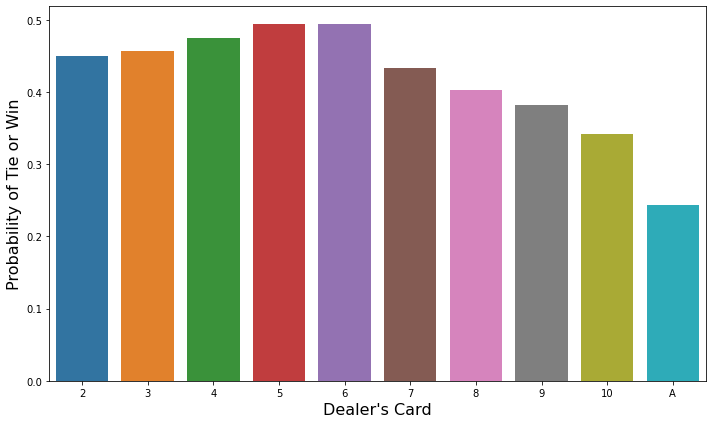

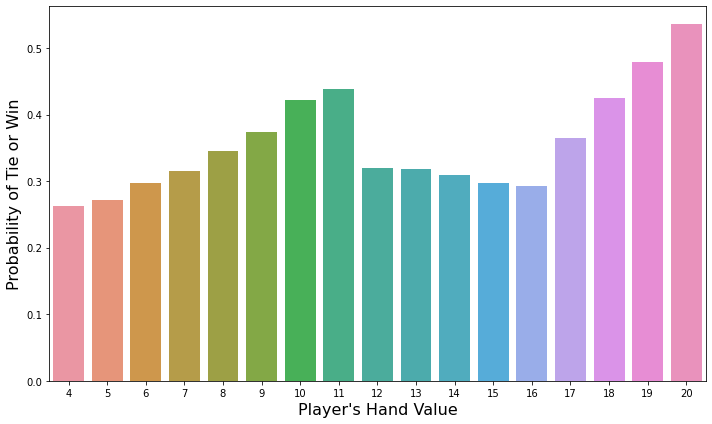

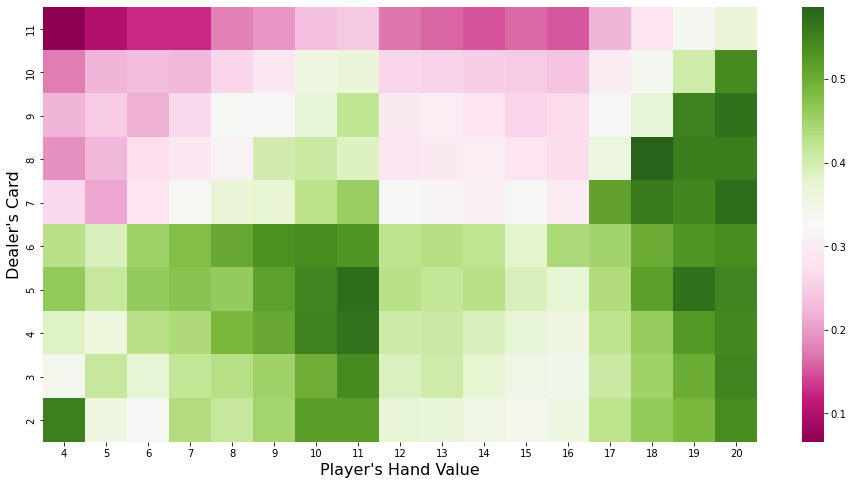

In [269]:
model_df_random = step(1) # 生成 random 模型各项数据
presentation(model_df_random) # 分析 random 模型数据

['player_total_initial', 'hit?', 'has_ace', 'dealer_card_num']
Epoch 1/200
1008/1008 [==============================] - 2s 2ms/step - loss: 0.6537
Epoch 2/200
1008/1008 [==============================] - 2s 2ms/step - loss: 0.6207
Epoch 3/200
1008/1008 [==============================] - 2s 2ms/step - loss: 0.6169
Epoch 4/200
1008/1008 [==============================] - 2s 2ms/step - loss: 0.6156
Epoch 5/200
1008/1008 [==============================] - 2s 2ms/step - loss: 0.6151
Epoch 6/200
1008/1008 [==============================] - 2s 2ms/step - loss: 0.6149
Epoch 7/200
1008/1008 [==============================] - 2s 2ms/step - loss: 0.6147
Epoch 8/200
1008/1008 [==============================] - 2s 2ms/step - loss: 0.6147
Epoch 9/200
1008/1008 [==============================] - 2s 2ms/step - loss: 0.6144
Epoch 10/200
1008/1008 [==============================] - 2s 2ms/step - loss: 0.6145
Epoch 11/200
1008/1008 [==============================] - 2s 2ms/step - loss: 0.6146
Epoch 12/20

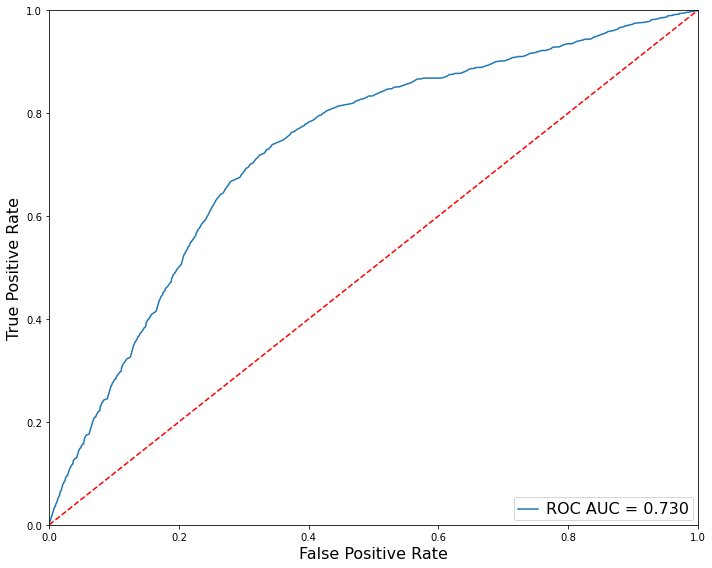

['player_total_initial', 'hit?', 'has_ace', 'dealer_card_num', 2, 3, 4, 5, 6, 7, 8, 9, 10, 'A']
Epoch 1/200
1008/1008 [==============================] - 2s 2ms/step - loss: 0.6395
Epoch 2/200
1008/1008 [==============================] - 2s 2ms/step - loss: 0.6064
Epoch 3/200
1008/1008 [==============================] - 2s 2ms/step - loss: 0.5946
Epoch 4/200
1008/1008 [==============================] - 2s 2ms/step - loss: 0.5889
Epoch 5/200
1008/1008 [==============================] - 2s 2ms/step - loss: 0.5855
Epoch 6/200
1008/1008 [==============================] - 2s 2ms/step - loss: 0.5829
Epoch 7/200
1008/1008 [==============================] - 2s 2ms/step - loss: 0.5807
Epoch 8/200
1008/1008 [==============================] - 2s 2ms/step - loss: 0.5791
Epoch 9/200
1008/1008 [==============================] - 2s 2ms/step - loss: 0.5779
Epoch 10/200
1008/1008 [==============================] - 2s 2ms/step - loss: 0.5765
Epoch 11/200
1008/1008 [==============================] - 2s 2m

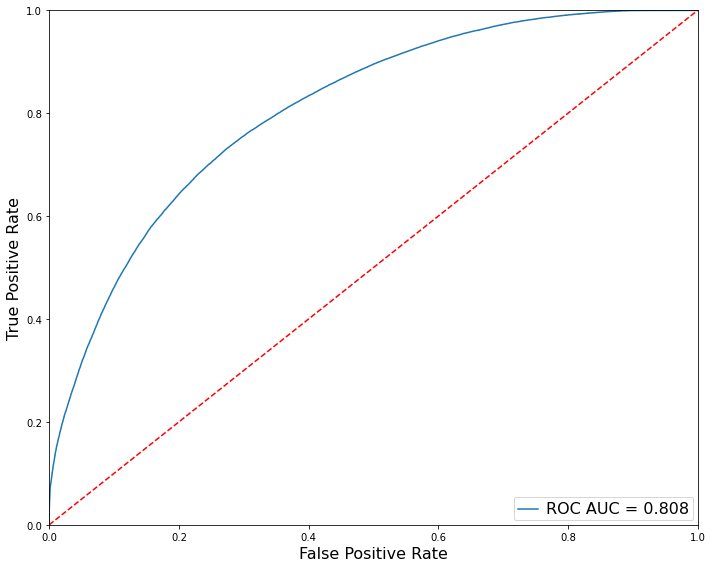

In [270]:
model_nn, pred_Y_train, actuals = train_nn_ca(model_df_random) # 用 random 模型训练是否是正确决策
plot_roc(pred_Y_train, actuals)
model_nn_bj, pred_Y_train_bust, actuals_bust = train_nn_ca2(model_df_random) # 用 random 模型训练玩家起手是否有 21 点
plot_roc(pred_Y_train_bust, actuals_bust)

-1.0    653
 1.0    487
 0.0     88
Name: 0, dtype: int64 1228
-1.0    650
 1.0    491
 0.0     75
Name: 0, dtype: int64 1216
-1.0    657
 1.0    475
 0.0     88
Name: 0, dtype: int64 1220
-1.0    677
 1.0    472
 0.0     86
Name: 0, dtype: int64 1235
-1.0    687
 1.0    461
 0.0     96
Name: 0, dtype: int64 1244
-1.0    661
 1.0    486
 0.0     83
Name: 0, dtype: int64 1230
-1.0    659
 1.0    475
 0.0     91
Name: 0, dtype: int64 1225
-1.0    658
 1.0    482
 0.0     98
Name: 0, dtype: int64 1238
-1.0    673
 1.0    486
 0.0     69
Name: 0, dtype: int64 1228
-1.0    709
 1.0    437
 0.0     88
Name: 0, dtype: int64 1234
-1.0    654
 1.0    477
 0.0     99
Name: 0, dtype: int64 1230
-1.0    635
 1.0    503
 0.0     87
Name: 0, dtype: int64 1225
-1.0    675
 1.0    452
 0.0    104
Name: 0, dtype: int64 1231
-1.0    666
 1.0    482
 0.0     85
Name: 0, dtype: int64 1233
-1.0    683
 1.0    452
 0.0     90
Name: 0, dtype: int64 1225
-1.0    668
 1.0    457
 0.0     89
Name: 0, dtype: int

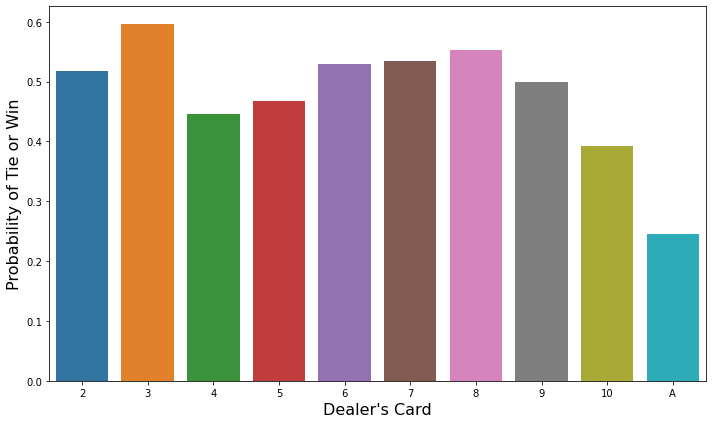

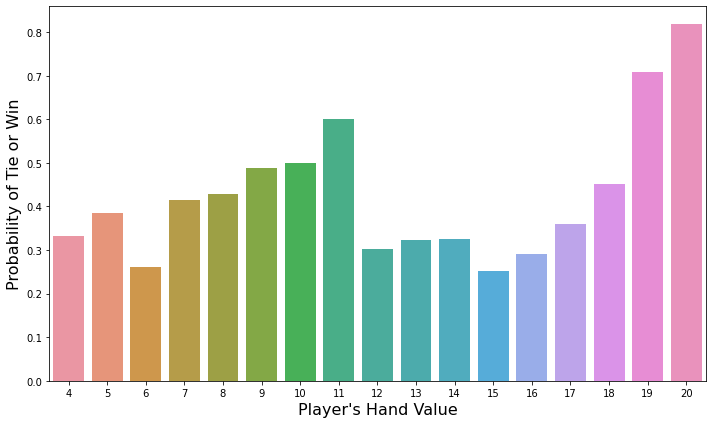

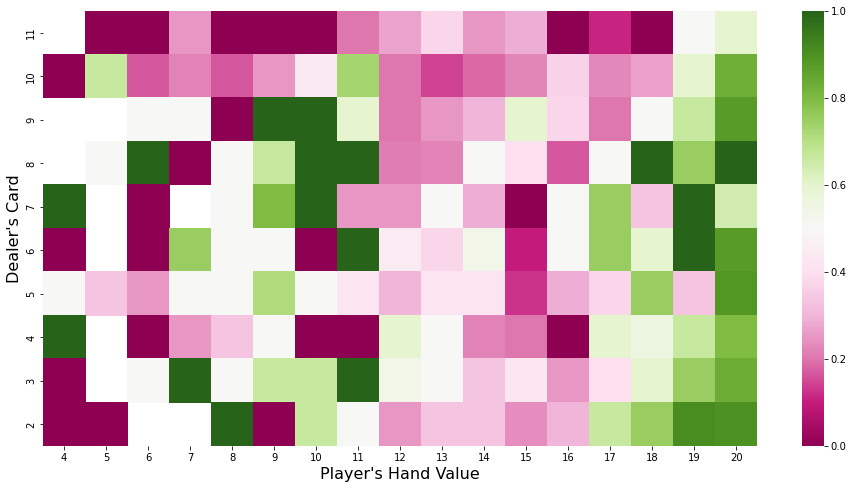

Random: 0.3499
Random: 0.4153
Random: 0.3964
    neural net hit frequency  naive strategy hit frequency
0                   1.000000                           1.0
1                   0.923077                           1.0
2                   0.695652                           1.0
3                   0.827586                           1.0
4                   0.885714                           1.0
5                   0.822222                           1.0
6                   0.942308                           1.0
7                   0.927273                           1.0
8                   0.866071                           0.0
9                   0.879630                           0.0
10                  0.815789                           0.0
11                  0.864078                           0.0
12                  0.850000                           0.0
13                  0.674157                           0.0
14                  0.321429                           0.0
15         

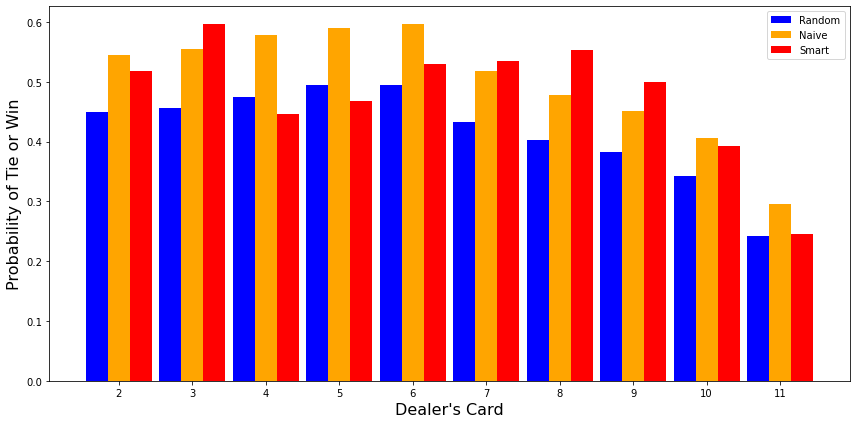

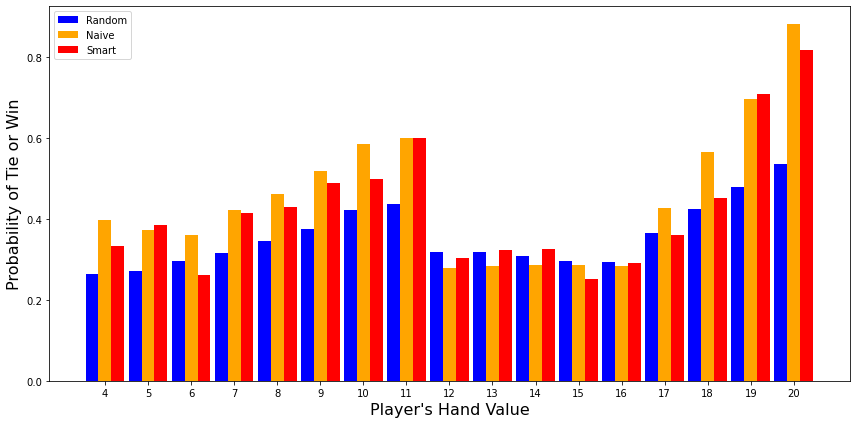

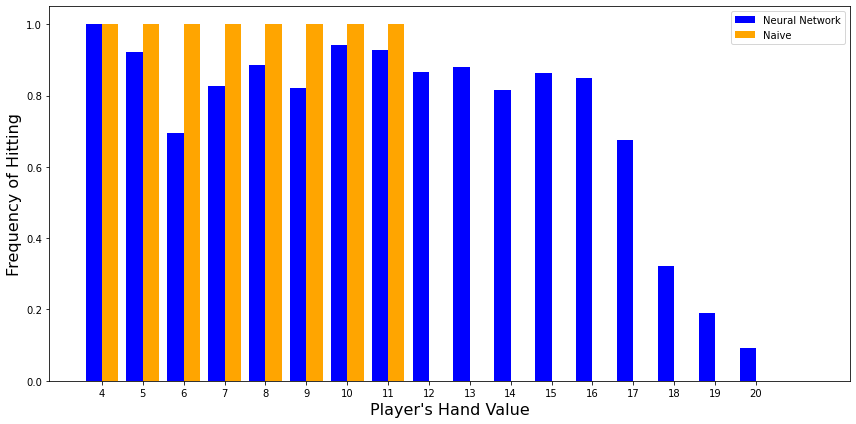

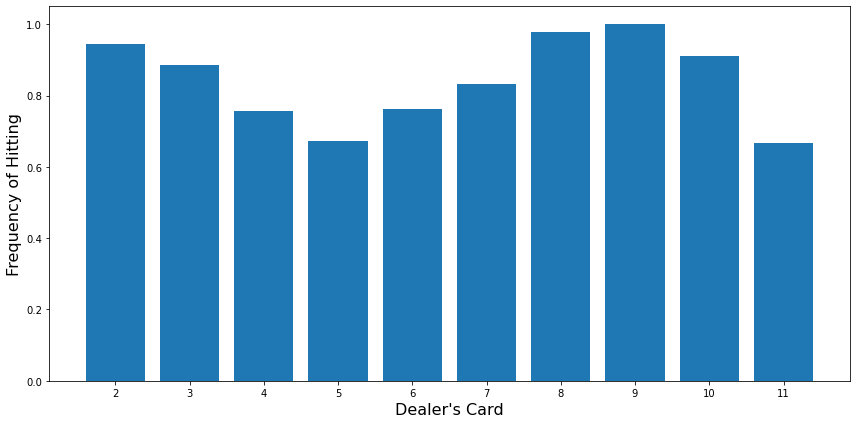

In [271]:
model_df_nn = step(2, model_nn_bj, pred_Y_train_bust) # 生成 NN 模型各项数据
presentation(model_df_nn) # 分析 NN 模型数据
# plot_mean()

# presentation(2, model_df_nn) # 分析 NN 模型数据
comparison(model_df_naive, model_df_random, model_df_nn) # 将 naive, random, NN 三个模型的数据对比分析
# print(model_df_naive, model_df_random, model_df_nn)